# About Dataset

This dataset contains two datasets. The first called plates has train, test and validation images for the 50 states. After running my dataset analysis and correction tool I found this dataset had duplicate images. I used that tool to create the new plates dataset that contains no duplicate images. I also added files for the District of Columbia(Washington DC) and 5 US territories so the new plates datset has a total of 56 classes.
The new plates dataset is a very high quality dataset. All images are originals, no augmented images are present in the dataset. The dataset was carefully constructed so that it does not contain any duplicate images. . All images are size 128 X 224 X 3 in jpg format. All images have been cropped so the the license plate occupies at least 90% of the pixels in any image. This ensures that even fairly simple models will achieve high training, validation and test accuracy. Also included is a csv file so that users can use that to create their own train, validation and test sets if desired

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


In [2]:
# Set the Parameters
batch_size = 32
img_height = 224
img_width = 224

In [3]:
seed = 1234
suffle = True

In [4]:
# Set the path to the dataset directory
data_dir = './new plates'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'valid')

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Create the training dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    seed=seed,
    shuffle=suffle
)

Found 8161 images belonging to 56 classes.


In [6]:
# Create the validation dataset
val_datagen = ImageDataGenerator(rescale=1./255)

val_ds = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
)

Found 280 images belonging to 56 classes.


In [7]:
# Create the test dataset
test_datagen = ImageDataGenerator(rescale=1./255)

test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 280 images belonging to 56 classes.


# Data Visualization

In [8]:
# Get the class names
plates_df = pd.read_csv('./new plates/plates.csv')
class_names = plates_df['labels'].unique()
class_names = np.sort(class_names)
class_names

array(['ALABAMA', 'ALASKA', 'AMERICAN SAMOA', 'ARIZONA', 'ARKANSAS',
       'CALIFORNIA', 'CNMI', 'COLORADO', 'CONNECTICUT', 'DELAWARE',
       'FLORIDA', 'GEORGIA', 'GUAM', 'HAWAI', 'IDAHO', 'ILLINOIS',
       'INDIANA', 'IOWA', 'KANSAS', 'KENTUCKY', 'LOUISIANA', 'MAINE',
       'MARYLAND', 'MASSACHUSETTS', 'MICHIGAN', 'MINNESOTA', 'MISSIPPI',
       'MISSOURI', 'MONTANA', 'NEBRASKA', 'NEVADA', 'NEW HAMPSHIRE',
       'NEW JERSEY', 'NEW MEXICO', 'NEW YORK', 'NORTH CAROLINA',
       'NORTH DAKOTA', 'OHIO', 'OKLAHOMA', 'OREGON', 'PENNSYLVANIA',
       'PUERTO RICO', 'RHODE ISLAND', 'SOUTH CAROLINA', 'SOUTH DAKOTA',
       'TENNESSEE', 'TEXAS', 'U S VIRGIN ISLANDS', 'UTAH', 'VERMONT',
       'VIRGINIA', 'WASHINGTON', 'WASHINGTON DC', 'WEST VIRGINIA',
       'WISCONSIN', 'WYOMING'], dtype=object)

In [9]:
# Get the number of classes
num_classes = len(class_names)
num_classes

56

In [10]:
# Get the number of images in the training dataset
num_train = len(train_ds.filenames)
num_train

8161

In [11]:
# Get the number of images in the validation dataset
num_val = len(val_ds.filenames)
# Get the number of images in the test dataset
num_test = len(test_ds.filenames)

num_val, num_test

(280, 280)

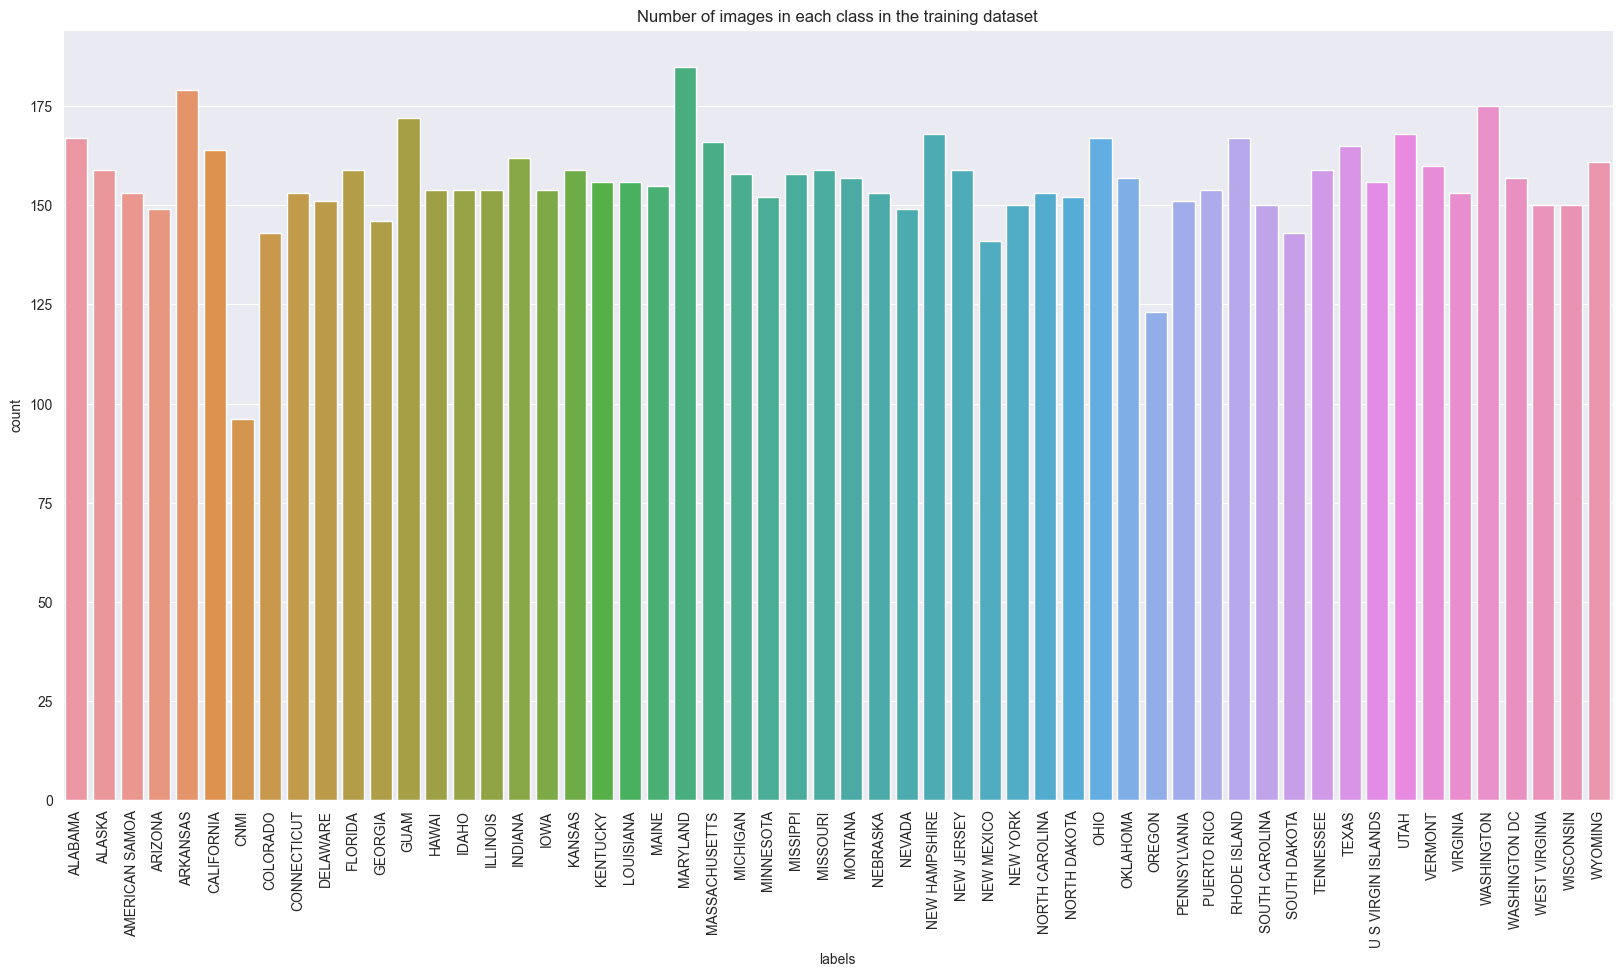

In [12]:
# Plot the number of images in each class in the training dataset
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(x='labels', data=plates_df, ax=ax)
ax.set_title('Number of images in each class in the training dataset')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

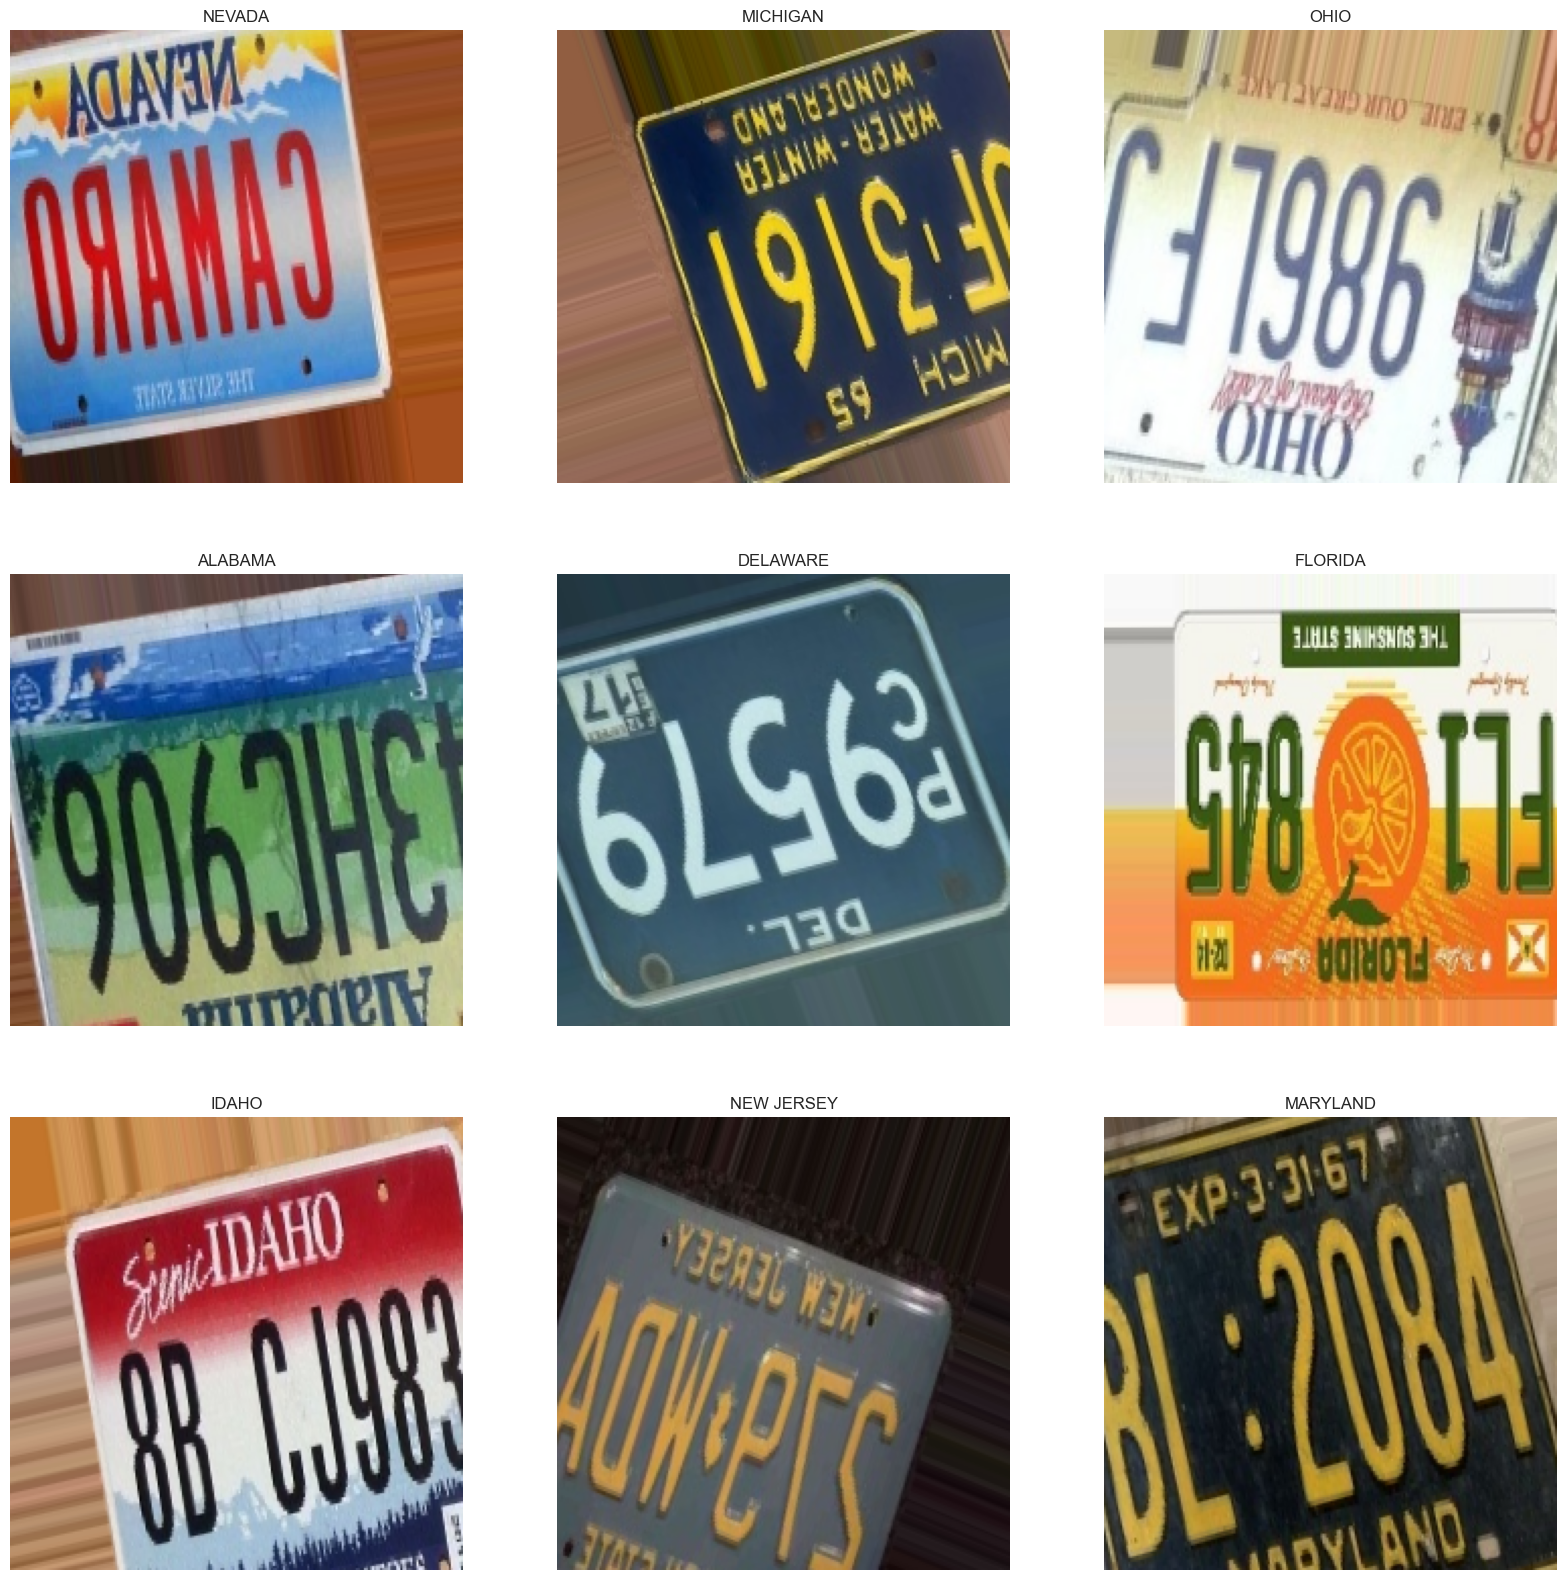

In [13]:
# Plot images with their labels
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for i in range(3):
    for j in range(3):
        img, label = train_ds.next()
        img = img[0]
        label = label[0]
        label = np.argmax(label)
        ax[i, j].imshow(img)
        ax[i, j].set_title(class_names[label])
        ax[i, j].axis('off')

plt.show()

# Create the model

In [14]:
# print((img_height, img_width, 3))
base_model = tf.keras.applications.MobileNetV2(
    input_shape = (224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 56)                71736     
                                                                 
Total params: 2329720 (8.89 MB)
Trainable params: 71736 (280.22 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [16]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
# Train the model
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
256/256 [==============================] - 132s 508ms/step - loss: 3.5747 - accuracy: 0.1579 - val_loss: 3.1964 - val_accuracy: 0.2393
Epoch 2/10
256/256 [==============================] - 127s 494ms/step - loss: 2.8591 - accuracy: 0.3078 - val_loss: 2.8644 - val_accuracy: 0.3250
Epoch 3/10
256/256 [==============================] - 118s 461ms/step - loss: 2.5627 - accuracy: 0.3805 - val_loss: 2.7791 - val_accuracy: 0.3321
Epoch 4/10
256/256 [==============================] - 119s 465ms/step - loss: 2.3929 - accuracy: 0.4172 - val_loss: 2.5767 - val_accuracy: 0.3893
Epoch 5/10
256/256 [==============================] - 131s 511ms/step - loss: 2.2774 - accuracy: 0.4436 - val_loss: 2.4576 - val_accuracy: 0.4286
Epoch 6/10
256/256 [==============================] - 123s 479ms/step - loss: 2.1860 - accuracy: 0.4672 - val_loss: 2.4346 - val_accuracy: 0.4143
Epoch 7/10
256/256 [==============================] - 129s 502ms/step - loss: 2.1205 - accuracy: 0.4756 - val_loss: 2.4938 -

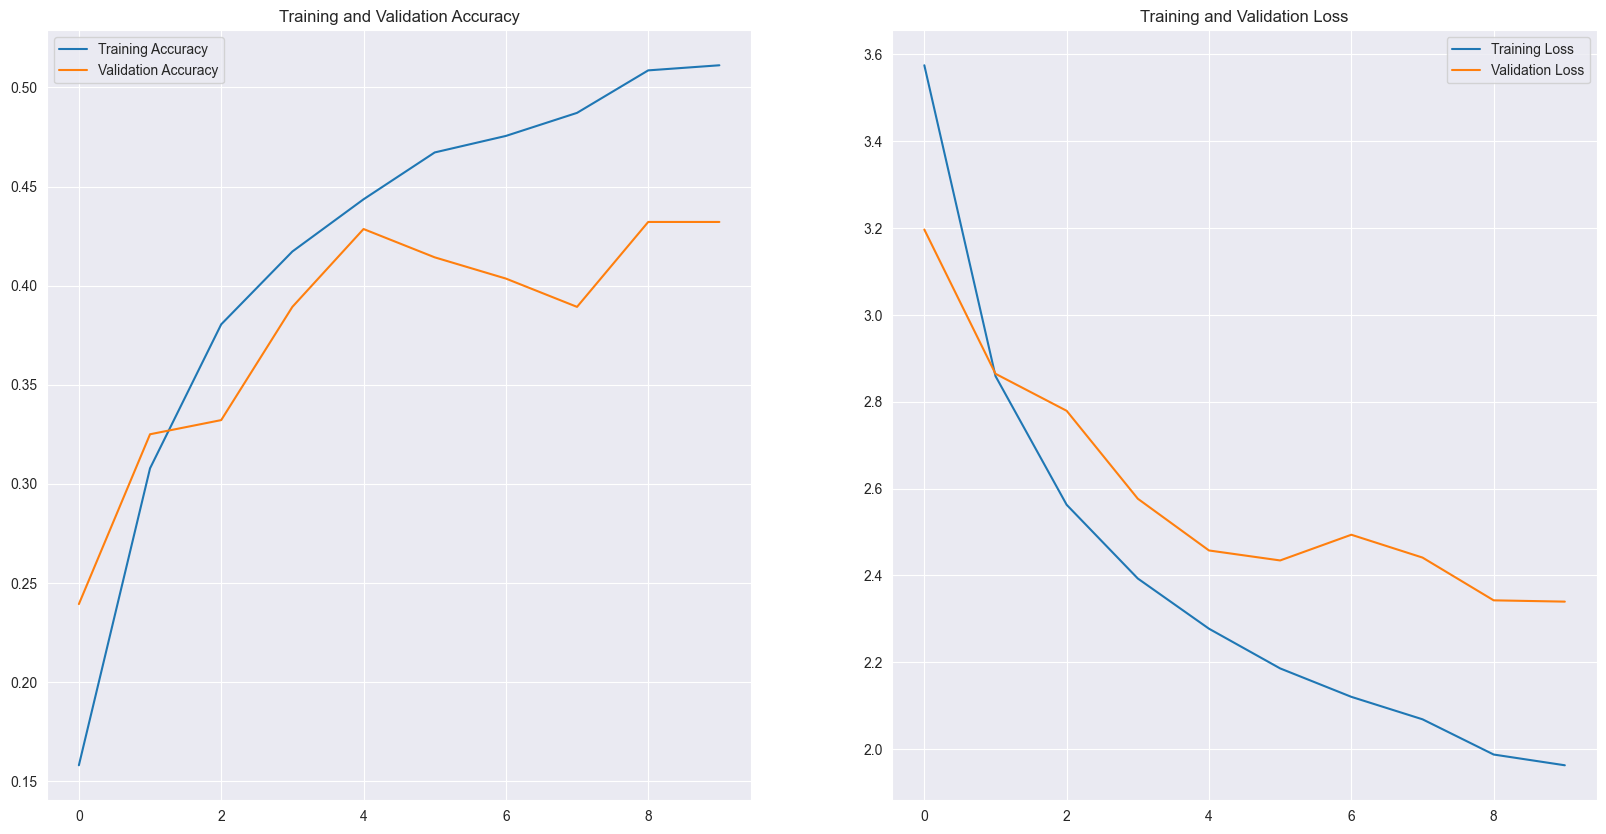

In [18]:
# Plot the training and validation accuracy and loss at each epoch
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(history.history['accuracy'], label='Training Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')
ax[0].legend()

ax[1].plot(history.history['loss'], label='Training Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title('Training and Validation Loss')
ax[1].legend()

plt.show()

In [19]:
# Evaluate the model on the test dataset
model.evaluate(test_ds)

9/9 [==============================] - 3s 345ms/step - loss: 2.6372 - accuracy: 0.3393


[2.6372392177581787, 0.3392857015132904]

In [20]:
# Get the predictions on the test dataset
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_pred

9/9 [==============================] - 4s 350ms/step


array([25, 46, 30, 39, 30, 13, 26, 34,  2, 52, 40,  4, 17, 34, 31, 51, 51,
       34, 30, 40, 51, 50, 15, 30, 46, 34, 38, 12, 39, 47, 25, 55, 39, 15,
       10, 25, 50, 15, 30,  0, 55,  5, 10, 42, 15, 30, 55, 33,  4, 46,  9,
       34, 23, 44, 13, 15, 31, 26, 30, 15, 30, 16, 27,  0, 49, 10, 50, 30,
       41, 30, 43, 30, 25, 15, 43, 17, 30, 40, 30, 34, 15, 49, 15, 27, 21,
       30, 43, 39, 30, 52, 44, 30,  4, 10, 28, 38, 39, 55, 27, 48, 36, 30,
        4, 49,  2, 51, 39, 30, 25, 30, 45, 30, 20, 44,  7, 40, 10, 17, 40,
       30, 15, 35, 43, 47, 15,  4, 34, 44, 28, 34, 15, 40, 44, 28, 30, 30,
       52,  4, 52, 41,  9, 17, 40,  2, 15, 15, 10, 17, 15, 30, 26, 50, 15,
       34,  4,  4, 16, 25,  5, 18,  0, 47, 30, 44, 33,  4, 17, 30, 39, 43,
        2, 40, 46, 44, 27, 26,  3, 45, 15, 10, 12, 40, 30, 43,  5, 11, 21,
       10, 39, 22, 46, 55,  9, 38,  4, 23,  8, 16, 30, 48, 16, 38, 30,  2,
       15,  7, 27, 14, 17, 51, 34, 34, 35, 26, 52, 22, 44, 34, 44, 30, 52,
       10, 15, 32, 44, 40

1/1 [==============================] - 0s 351ms/step


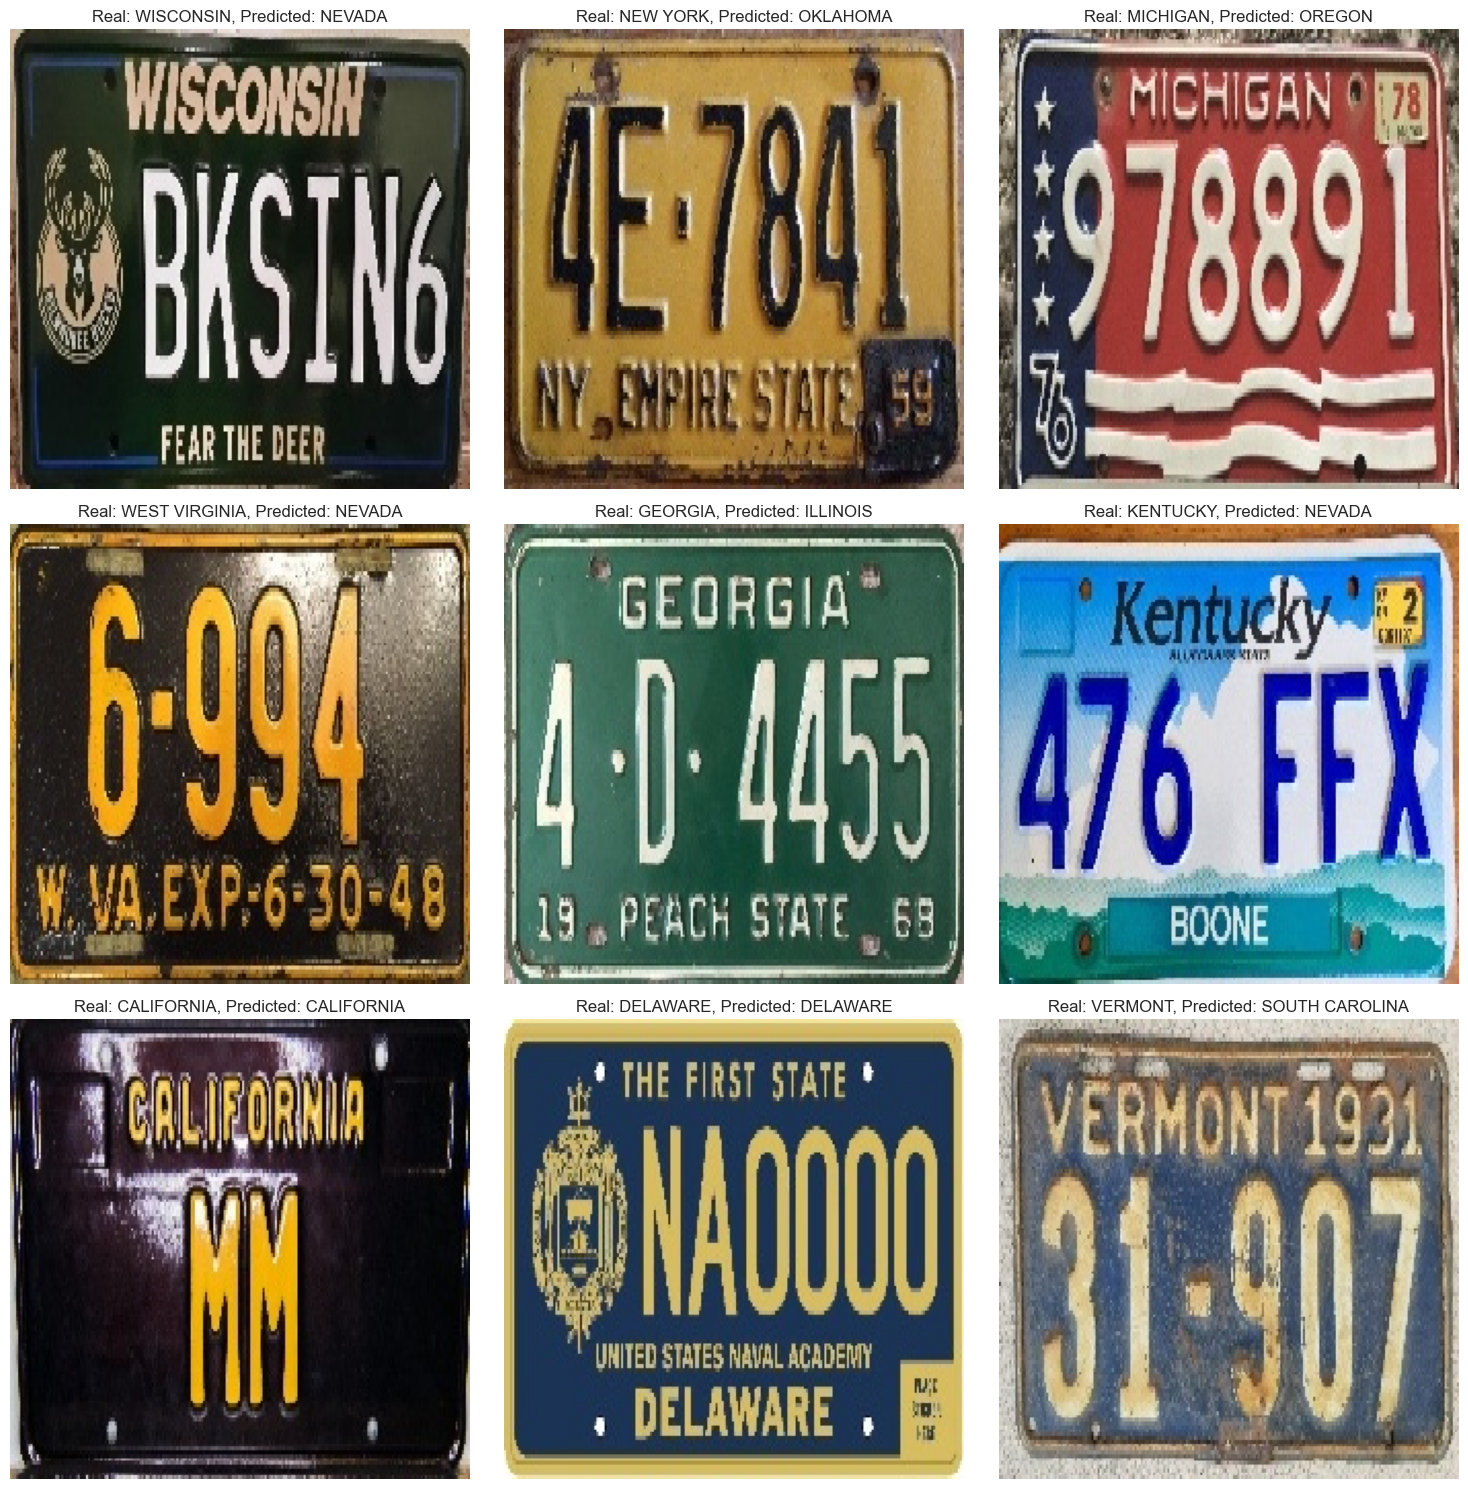

In [26]:
# Plot 10 images with the real label vs the predicted
num_samples = len(test_ds.filenames)
indices =  np.arange(num_samples)
real_labels = test_ds.classes


images, labels = next(test_ds)
predicted_labels = model.predict(images)
predicted_labels = np.argmax(predicted_labels, axis=1)

plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    real = class_names[np.argmax(labels[i])]
    predicted = class_names[predicted_labels[i]]
    plt.title(f'Real: {real}, Predicted: {predicted}')
    plt.axis('off')

plt.tight_layout()
plt.show()
